# NB3 - Analysis on SUMMA outputs forced by GMET and ICAR climate projection

In [1]:
%matplotlib inline  
import os
import sys
import glob
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

from scripts.utility import AutoVivification
import scripts.colors as ccmap

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


## Dask
**Without Dask, loading netcdf takes much longer. This setup is a machine specific (here for NCAR Casper HPC). Please adjust this section, depending on your machine.**

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(processes=2, memory="100GB", queue='casper',
                  walltime='00:30:00')
cluster.scale(jobs=12)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:45619,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## 1. settings

In [3]:
# directories
main_path  = '/glade/campaign/ral/hap/mizukami/archive/pnw_hydrology/final_archive_v1' # !!! This is top directory of the dataset.
geo_path   = os.path.join(main_path, 'ancillary_data','geospatial_data')
nrni_path  = os.path.join(main_path, 'ancillary_data')
figure_path = 'NB3_figures'
os.makedirs(figure_path, exist_ok=True)

In [4]:
# Mete dictironaries
gcm_runs = {
            'CanESM5':             {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},
            'CMCC-CM2-SR5':        {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},    
            'NorESM2-MM':          {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},
            'MIROC-ES2L':          {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},
            'MPI-M.MPI-ESM1-2-LR': {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},
            'CanESM2':             {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
            'CCSM4':               {'scen':['hist', 'rcp85'], 'cmip':5},
            'CMCC-CM':             {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
            'CNRM-CM5':            {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
            'MIROC5':              {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
            'MRI-CGCM3':           {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
           }

retro_runs = {
            'GMET':{'period':'control'}
            }

scens = {
         'hist':   {'time':slice('1975-01-01', '2004-12-31'), 'period':['control']},
         'ssp245': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'ssp370': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'ssp585': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'rcp45':  {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'rcp85':  {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
        }

periods = {
         'control':  {'name':'WY1980-2004', 'time':slice('1980-10-01', '2004-09-30'), 'lc':'xkcd:blue'},
         '2040s':    {'name':'WY2030-2060', 'time':slice('2029-10-01', '2060-09-30'), 'lc':'xkcd:orange'},
         '2080s':    {'name':'WY2070-2099', 'time':slice('2069-10-01', '2099-09-30'), 'lc':'xkcd:magenta'},
          }

ensembles = {
             'cmip-hist':     {'cmip':[5,6], 'scen':['hist']},
             'cmip6-hist':    {'cmip':[6],   'scen':['hist']},
             'cmip5-hist':    {'cmip':[5],   'scen':['hist']},
             'cmip6-ssp245':  {'cmip':[6],   'scen':['hist', 'ssp245']},
             'cmip6-ssp585':  {'cmip':[6],   'scen':['hist', 'ssp585']},
             'cmip5-rcp85':   {'cmip':[5],   'scen':['hist', 'rcp85']},
             'cmip6':         {'cmip':[6],   'scen':['hist', 'ssp245', 'ssp370', 'ssp585']},
             'cmip5':         {'cmip':[5],   'scen':['hist', 'rcp45','rcp85']},
             'high-emission': {'cmip':[5,6], 'scen':['ssp585','rcp85']},
            }

mean_ensemble_name='cmip-hist' # select from ensembles dictionary

sims   =  {**retro_runs, **gcm_runs}
gcm_names   = list(gcm_runs.keys())
retro_names = list(retro_runs.keys())
sim_names   = list(sims.keys())

# including variables
summa_variables = {
    'scalarTotalRunoff_mean':{'scale':1, 'mon_agg':'sum'},
    'scalarTotalET_mean':    {'scale':1, 'mon_agg':'sum'},
    'scalarSWE':             {'scale':1, 'mon_agg':'mean'},
}
met_variables = {
    'prec': {'scale':1,      'mon_agg':'sum'},
}
variables = {**summa_variables, **met_variables}

## 2.Load data 

### 2.1 geospatial data

In [5]:
%%time

df_huc12 = gpd.read_file(os.path.join(geo_path, 'HUC12_MERIT_PNW.gpkg'))
df_huc12['geometry'] = df_huc12.geometry.simplify(0.01) # simplified
# clean attributes
df_huc12.drop(columns=['SourceData','SourceOrig','LoadDate','NonContr_1','NonContrib','HUC12','HUType','pfaf150','pfaf_merit','PERIM_GEO'], inplace=True)
df_huc12 = df_huc12.rename(columns={'HUCIDXint':'hruId'})
df_huc12 = df_huc12.set_index('hruId')

df_site  = pd.read_csv(os.path.join(geo_path, 'PNW_flow_site.csv'), index_col='location_name')

CPU times: user 19.7 s, sys: 612 ms, total: 20.3 s
Wall time: 22 s


### 2.2. Read summa outputs

Read summa daily output, aggregate it to monthly and store it in dictionary ds_summa[sim_case][scenario]

In [6]:
%%time
# read SUMMA variables per HUC12 over the entire PWN. 
def summa_preprocess(ds):
    ds = ds[[*summa_variables]]
    for var, meta in summa_variables.items():
        ds[var] = ds[var]*meta['scale']
    return ds

def met_preprocess(ds):
    ds = ds[[*met_variables]]
    for var, meta in met_variables.items():
        ds[var] = ds[var]*meta['scale']
    return ds

# get GCM sim
ds_summa = AutoVivification()
for gcm_name, meta in gcm_runs.items():
    for scen in meta['scen']:
        analysis_period = scens[scen]['time']

        if scen=='hist' and meta['cmip']==5: # for cmip5 historical period, use rcp85 data
            case = f'{gcm_name}_rcp85'
        elif scen=='hist' and meta['cmip']==6: # for cmip6 historical period, use ssp585 data
            case = f'{gcm_name}_ssp585'
        else: # for future period
            case = f'{gcm_name}_{scen}'
        
        nclist=glob.glob(os.path.join(main_path, case, f'{case}_summa_daily.nc'))
        ds_tmp = xr.open_mfdataset(nclist, data_vars='minimal', parallel=True, preprocess=summa_preprocess, chunks='auto')
        ds_tmp = ds_tmp.sel(time=analysis_period).resample(time='MS').mean()
        for var, meta_var in summa_variables.items():
            if meta_var['mon_agg']=='sum':
                ds_tmp[var] = ds_tmp[var]*30       
        ds_summa[gcm_name][scen] = ds_tmp.load()
        
        nclist=glob.glob(os.path.join(main_path, case, f'{case}_daily_t_p.nc'))
        ds_tmp = xr.open_mfdataset(nclist, data_vars='minimal', parallel=True, preprocess=met_preprocess, chunks='auto')
        ds_tmp = ds_tmp.sel(time=analysis_period).resample(time='MS').mean()
        for var, meta_var in met_variables.items():
            if meta_var['mon_agg']=='sum':
                ds_tmp[var] = ds_tmp[var]*30
        ds_summa[gcm_name][scen] = ds_summa[gcm_name][scen].merge(ds_tmp.load())
        
        print(f'{gcm_name}_{scen}')

CanESM5_hist
CanESM5_ssp245
CanESM5_ssp370
CanESM5_ssp585
CMCC-CM2-SR5_hist
CMCC-CM2-SR5_ssp245
CMCC-CM2-SR5_ssp370
CMCC-CM2-SR5_ssp585
NorESM2-MM_hist
NorESM2-MM_ssp245
NorESM2-MM_ssp370
NorESM2-MM_ssp585
MIROC-ES2L_hist
MIROC-ES2L_ssp245
MIROC-ES2L_ssp370
MIROC-ES2L_ssp585
MPI-M.MPI-ESM1-2-LR_hist
MPI-M.MPI-ESM1-2-LR_ssp245
MPI-M.MPI-ESM1-2-LR_ssp370
MPI-M.MPI-ESM1-2-LR_ssp585
CanESM2_hist
CanESM2_rcp45
CanESM2_rcp85
CCSM4_hist
CCSM4_rcp85
CMCC-CM_hist
CMCC-CM_rcp45
CMCC-CM_rcp85
CNRM-CM5_hist
CNRM-CM5_rcp45
CNRM-CM5_rcp85
MIROC5_hist
MIROC5_rcp45
MIROC5_rcp85
MRI-CGCM3_hist
MRI-CGCM3_rcp45
MRI-CGCM3_rcp85
CPU times: user 30.2 s, sys: 6.48 s, total: 36.7 s
Wall time: 3min 30s


In [10]:
%%time
# read basin mean SUMMA variables. SUMMA simulation forced by ESMs

ds_summa_basin = AutoVivification()
for gcm_name, meta in gcm_runs.items():
    for scen in meta['scen']:
        analysis_period = scens[scen]['time']

        if scen=='hist' and meta['cmip']==5: # for cmip5 historical period, use rcp85 data
            case = f'{gcm_name}_rcp85'
        elif scen=='hist' and meta['cmip']==6: # for cmip6 historical period, use ssp585 data
            case = f'{gcm_name}_ssp585'
        else: # for future period
            case = f'{gcm_name}_{scen}'
        
        nclist=glob.glob(os.path.join(main_path, case, f'{case}_summa_daily_basin_mean.nc'))
        ds_tmp = xr.open_mfdataset(nclist, data_vars='minimal', parallel=True, preprocess=summa_preprocess, chunks='auto')
        ds_tmp = ds_tmp.sel(time=analysis_period).resample(time='MS').mean()
        for var, meta_var in summa_variables.items():
            if meta_var['mon_agg']=='sum':
                ds_tmp[var] = ds_tmp[var]*30
        ds_summa_basin[gcm_name][scen] = ds_tmp.load()

        nclist=glob.glob(os.path.join(main_path, case, f'{case}_daily_t_p_basin_mean.nc'))
        ds_tmp = xr.open_mfdataset(nclist, data_vars='minimal', parallel=True, preprocess=met_preprocess, chunks='auto')
        ds_tmp = ds_tmp.sel(time=analysis_period).resample(time='MS').mean()
        for var, meta_var in met_variables.items():
            if meta_var['mon_agg']=='sum':
                ds_tmp[var] = ds_tmp[var]*30
        ds_summa_basin[gcm_name][scen] = ds_summa_basin[gcm_name][scen].merge(ds_tmp.load())
        
        print(f'{gcm_name}_{scen}')

CanESM5_hist
CanESM5_ssp245
CanESM5_ssp370
CanESM5_ssp585
CMCC-CM2-SR5_hist
CMCC-CM2-SR5_ssp245
CMCC-CM2-SR5_ssp370
CMCC-CM2-SR5_ssp585
NorESM2-MM_hist
NorESM2-MM_ssp245
NorESM2-MM_ssp370
NorESM2-MM_ssp585
MIROC-ES2L_hist
MIROC-ES2L_ssp245
MIROC-ES2L_ssp370
MIROC-ES2L_ssp585
MPI-M.MPI-ESM1-2-LR_hist
MPI-M.MPI-ESM1-2-LR_ssp245
MPI-M.MPI-ESM1-2-LR_ssp370
MPI-M.MPI-ESM1-2-LR_ssp585
CanESM2_hist
CanESM2_rcp45
CanESM2_rcp85
CCSM4_hist
CCSM4_rcp85
CMCC-CM_hist
CMCC-CM_rcp45
CMCC-CM_rcp85
CNRM-CM5_hist
CNRM-CM5_rcp45
CNRM-CM5_rcp85
MIROC5_hist
MIROC5_rcp45
MIROC5_rcp85
MRI-CGCM3_hist
MRI-CGCM3_rcp45
MRI-CGCM3_rcp85
CPU times: user 7.36 s, sys: 600 ms, total: 7.96 s
Wall time: 2min 30s


## 3. Compute annual and seasonal mean 

water fluxes and temperature - mean

In [10]:
%%time
ds_summa_annual = AutoVivification()
for case, meta in gcm_runs.items():
    for scen in meta['scen']:
        for period in scens[scen]['period']:
            ds_summa_annual[case][scen][period] = ds_summa[case][scen].drop_vars('scalarSWE').sel(time=periods[period]['time']).mean('time')
            for var, _ in variables.items():
                if var not in ['airtemp_mean', 'scalarSWE', 'hru']:
                    ds_summa_annual[case][scen][period][var] = ds_summa_annual[case][scen][period][var]*12

CPU times: user 788 ms, sys: 8.68 ms, total: 797 ms
Wall time: 866 ms


Snow water equivalent - annual max

In [11]:
%%time
for case, meta in gcm_runs.items():
    for scen in meta['scen']:
        for period in scens[scen]['period']:
            ds_summa_annual_SWEmax        = ds_summa[case][scen]['scalarSWE'].sel(time=periods[period]['time']).resample(time='YS').max('time', skipna=False).mean('time')
            ds_summa_annual_SWEmax        = ds_summa_annual_SWEmax.rename('SWEmax')
            ds_summa_annual[case][scen][period] = ds_summa_annual[case][scen][period].merge(ds_summa_annual_SWEmax)

CPU times: user 1.3 s, sys: 7.55 ms, total: 1.31 s
Wall time: 1.39 s


seasonal mean

In [12]:
%%time
ds_summa_season = AutoVivification()
for case, meta in gcm_runs.items():
    for scen in meta['scen']:
        for period in scens[scen]['period']:
            ds_summa_season[case][scen][period] = ds_summa[case][scen].sel(time=periods[period]['time']).groupby("time.season").mean(dim="time")

CPU times: user 9.49 s, sys: 5.46 s, total: 15 s
Wall time: 16.3 s


emsemble mean of annual mean over period

In [13]:
ensemble_name='high-emission'

# -------------------
print('Computing ensemble mean.....')
# -------------------
gcm_plots = {gcm: meta['scen'] for gcm, meta in gcm_runs.items() if meta['cmip'] in ensembles[ensemble_name]['cmip'] }

ds_ens_mean_annual = {}
count = 0 
for gcm_name, scen_list in gcm_plots.items():
    if count==0:
        ds_ens_mean_annual['control'] = ds_summa_annual[gcm_name]['hist']['control']
    else:
        ds_ens_mean_annual['control'] = ds_ens_mean_annual['control'] + ds_summa_annual[gcm_name]['hist']['control']
    count+=1
# emsemble mean
ds_ens_mean_annual['control'] = ds_ens_mean_annual['control']/count

count = 0 
for gcm_name, scen_list in gcm_plots.items():
    for scen in scen_list:
        if scen=='hist':
            continue
        if count==0:
            ds_ens_mean_annual['2040s']  = ds_summa_annual[gcm_name][scen]['2040s']
            ds_ens_mean_annual['2080s']  = ds_summa_annual[gcm_name][scen]['2080s']
        else:
            ds_ens_mean_annual['2040s']  = ds_ens_mean_annual['2040s'] + ds_summa_annual[gcm_name][scen]['2040s']
            ds_ens_mean_annual['2080s']  = ds_ens_mean_annual['2080s'] + ds_summa_annual[gcm_name][scen]['2080s']
        count+=1
        
# emsemble mean
ds_ens_mean_annual['2040s'] = ds_ens_mean_annual['2040s']/count
ds_ens_mean_annual['2080s'] = ds_ens_mean_annual['2080s']/count

Computing ensemble mean.....


## 4. Compute Annual mean change

Each future period for each GCM and scenario

In [14]:
var_list = {'prec':           'pdiff',
            'scalarTotalET_mean':     'pdiff',
            'scalarTotalRunoff_mean': 'pdiff',
            'SWEmax':                 'diff'}

ds_summa_change = AutoVivification()
for case, meta in gcm_runs.items():
    for scen in meta['scen']:
        for period in scens[scen]['period']:
            if period == 'hist':
                continue
            for var, method in var_list.items():
                ds_summa_change[case][scen][period][var] = ds_summa_annual[case][scen][period][var] - ds_summa_annual[case]['hist']['control'][var]
                if method == 'pdiff':
                    ds_summa_change[case][scen][period][var] = ds_summa_change[case][scen][period][var]/ds_summa_annual[case]['hist']['control'][var]*100


Each future period for one emsemble mean

In [15]:
ds_ens_mean_annual_change = AutoVivification()
for period in periods.keys():
    if period == 'control':
        continue
    for var, method in var_list.items():
        ds_ens_mean_annual_change[period][var] = ds_ens_mean_annual[period][var] - ds_ens_mean_annual['control'][var]
        if method == 'pdiff':
            ds_ens_mean_annual_change[period][var] = ds_ens_mean_annual_change[period][var]/ds_ens_mean_annual['control'][var]*100  

## 5. Mapping

In [16]:
# some local plot setups

cm = {'general'  : mpl.colormaps['Spectral_r'],
      'diff1':     ccmap.cmap_summa_diff,
      'diff2':     ccmap.cmap_summa_swe_diff}

cbar_kwrgs = {"orientation":"horizontal", "shrink":0.92, "pad":0.03, 'extend':'both'}

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs}

hruVar = {'prec':           {'name':'Precip', 'vmin':20, 'vmax':2000, 'cm':cm['general'], 'extend':'both', 'unit':'mm',  **style_kwargs},
          'scalarTotalET_mean':     {'name':'ET',     'vmin':20, 'vmax':2000, 'cm':cm['general'], 'extend':'both', 'unit':'mm',  **style_kwargs},
          'scalarTotalRunoff_mean': {'name':'Runoff', 'vmin':20, 'vmax':2000, 'cm':cm['general'], 'extend':'both', 'unit':'mm',  **style_kwargs},
          'SWEmax':                 {'name':'SWEmax', 'vmin':20, 'vmax':2000, 'cm':cm['general'], 'extend':'max',  'unit':'mm',  **style_kwargs}
         } 

hruVar_diff = {'prec':           {'name':'Precip', 'vmin':-40,  'vmax':40,  'cm':cm['diff1'], 'extend':'both', 'unit':'%', **style_kwargs},
               'scalarTotalET_mean':     {'name':'ET',     'vmin':-40,  'vmax':40,  'cm':cm['diff1'], 'extend':'both', 'unit':'%', **style_kwargs},
               'scalarTotalRunoff_mean': {'name':'Runoff', 'vmin':-40,  'vmax':40,  'cm':cm['diff1'], 'extend':'both', 'unit':'%', **style_kwargs},
               'SWEmax':                 {'name':'SWEmax', 'vmin':-150, 'vmax':0,   'cm':cm['diff2'], 'extend':'both', 'unit':'mm', **style_kwargs}
               } 

### 5.1 Individual GCM and scenario

In [17]:
df_summa = AutoVivification()
for case, _ in gcm_runs.items():    
    df_summa[case] = df_huc12
    for var, _ in hruVar.items():
        df_var = ds_summa_annual[case]['hist']['control'][var].to_dataframe()
        df_summa[case] = df_summa[case].merge(df_var,left_index=True, right_index=True)

In [18]:
df_summa_diff = AutoVivification()
for case, meta in gcm_runs.items():
    for scen in meta['scen']:
        for period in scens[scen]['period']:
            if period == 'control':
                continue
            df_summa_diff[case][scen][period] = df_huc12
            for var, _ in hruVar.items():
                df_var = ds_summa_change[case][scen][period][var].to_dataframe()
                df_summa_diff[case][scen][period] = df_summa_diff[case][scen][period].merge(df_var, left_index=True, right_index=True)

In [19]:
def add_ylabel(ax, text, fontsize=12):
    return ax.text(-0.07, 0.55, text, va='center', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=fontsize)

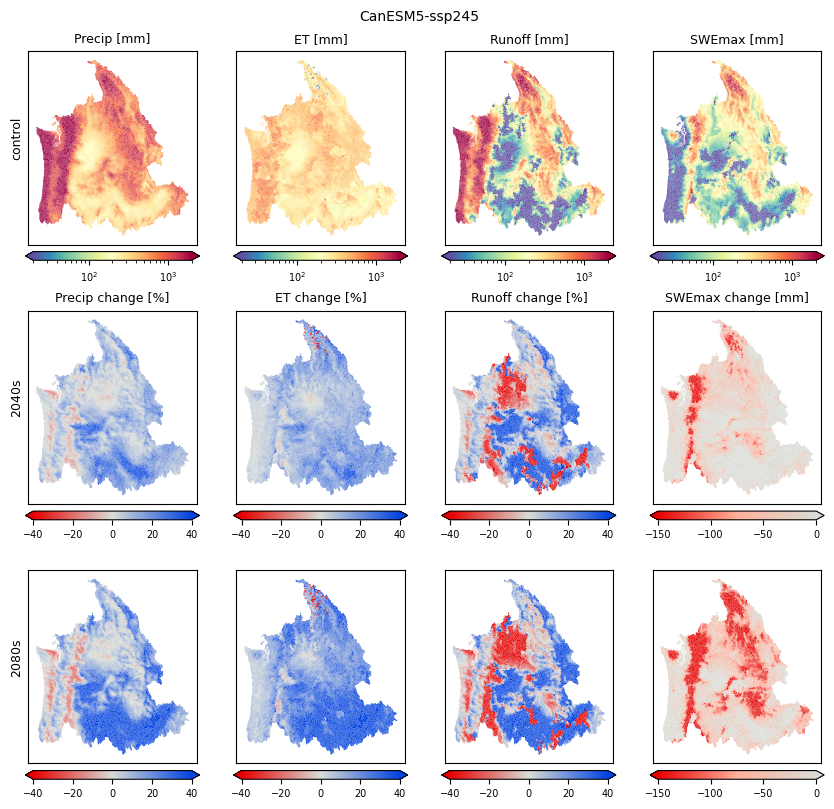

In [20]:
plot_case='CanESM5'
scen='ssp245'

nrows=3; ncols=4
fig1, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(8.5, 8.25))
plt.subplots_adjust(left=0.0275, bottom=0.020, right=0.985, top=0.935, hspace=0.1, wspace=0.1)

for col, (var, _) in enumerate(hruVar.items()):
    df_summa[plot_case].plot(ax=ax[0, col], column=var, cmap=hruVar[var]['cm'], norm=mpl.colors.LogNorm(vmin=hruVar[var]['vmin'], vmax=hruVar[var]['vmax']), legend=False)
    df_summa_diff[plot_case][scen]['2040s'].plot(ax=ax[1, col], column=var, cmap=hruVar_diff[var]['cm'], vmin=hruVar_diff[var]['vmin'], vmax=hruVar_diff[var]['vmax'], legend=False)
    df_summa_diff[plot_case][scen]['2080s'].plot(ax=ax[2, col], column=var, cmap=hruVar_diff[var]['cm'], vmin=hruVar_diff[var]['vmin'], vmax=hruVar_diff[var]['vmax'], legend=False)

    ax[0,col].set_xticks([])
    ax[0,col].set_yticks([])
    ax[0,col].set_title('%s [%s]'%(hruVar[var]['name'], hruVar[var]['unit']), fontsize=9);
    ax[1,col].set_title('%s change [%s]'%(hruVar_diff[var]['name'], hruVar_diff[var]['unit']), fontsize=9);

    points = ax[0,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[0,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
    points = ax[1,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[1,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
    points = ax[2,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[2,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
add_ylabel(ax[0, 0], 'control', fontsize=9)
add_ylabel(ax[1, 0], '2040s', fontsize=9)
add_ylabel(ax[2, 0], '2080s', fontsize=9)
    
fig1.suptitle(f'{plot_case}-{scen}', fontsize=10, y=0.985);
plt.savefig(os.path.join('NB3_figures', f'NB13_annual_map_{plot_case}_{scen}.png'), dpi=200)

### 5.2. ensemble

In [21]:
df_ens_mean = df_huc12
for var, _ in hruVar.items():
    df_var = ds_ens_mean_annual['control'][var].to_dataframe()
    df_ens_mean = df_ens_mean.merge(df_var,left_index=True, right_index=True)

df_ens_mean_diff = AutoVivification()
for period in periods.keys():
    if period == 'control':
        continue
    df_ens_mean_diff[period] = df_huc12
    for var, _ in hruVar.items():
        df_var = ds_ens_mean_annual_change[period][var].to_dataframe()
        df_ens_mean_diff[period] = df_ens_mean_diff[period].merge(df_var, left_index=True, right_index=True)

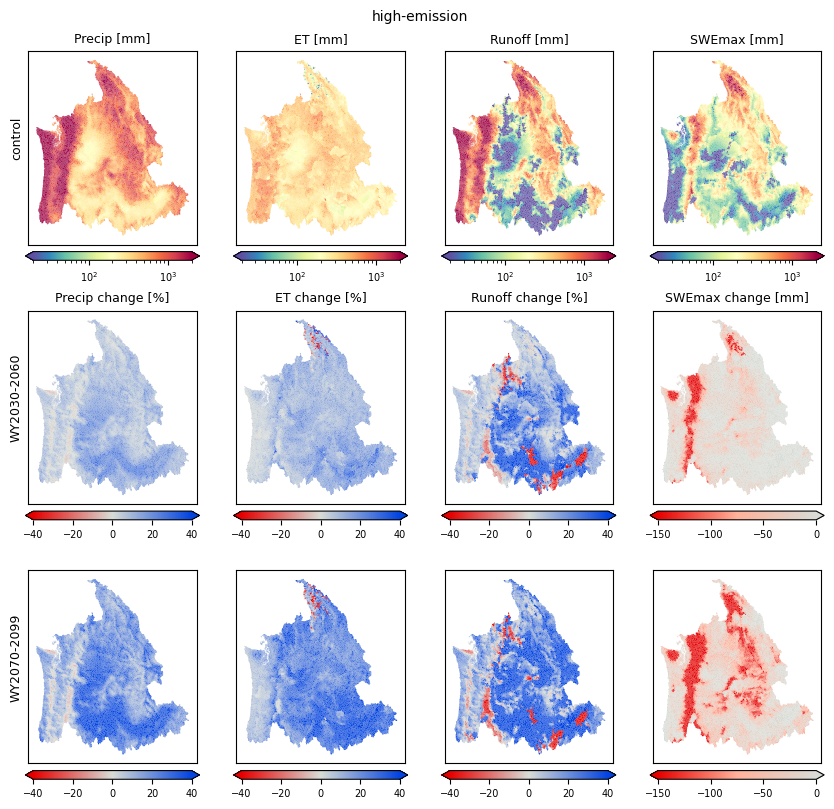

In [22]:
nrows=3; ncols=4
fig1, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(8.5, 8.25))
plt.subplots_adjust(left=0.0275, bottom=0.020, right=0.985, top=0.935, hspace=0.1, wspace=0.1)

for col, (var, _) in enumerate(hruVar.items()):
    df_ens_mean.plot(ax=ax[0, col], column=var, cmap=hruVar[var]['cm'], norm=mpl.colors.LogNorm(vmin=hruVar[var]['vmin'], vmax=hruVar[var]['vmax']), legend=False)
    df_ens_mean_diff['2040s'].plot(ax=ax[1, col], column=var, cmap=hruVar_diff[var]['cm'], vmin=hruVar_diff[var]['vmin'], vmax=hruVar_diff[var]['vmax'], legend=False)
    df_ens_mean_diff['2080s'].plot(ax=ax[2, col], column=var, cmap=hruVar_diff[var]['cm'], vmin=hruVar_diff[var]['vmin'], vmax=hruVar_diff[var]['vmax'], legend=False)

    ax[0,col].set_xticks([])
    ax[0,col].set_yticks([])
    ax[0,col].set_title('%s [%s]'%(hruVar[var]['name'], hruVar[var]['unit']), fontsize=9);
    ax[1,col].set_title('%s change [%s]'%(hruVar_diff[var]['name'], hruVar_diff[var]['unit']), fontsize=9);

    points = ax[0,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[0,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
    points = ax[1,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[1,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
    points = ax[2,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[2,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
add_ylabel(ax[0, 0], 'control', fontsize=9)
add_ylabel(ax[1, 0], 'WY2030-2060', fontsize=9)
add_ylabel(ax[2, 0], 'WY2070-2099', fontsize=9)
    
fig1.suptitle(f'{ensemble_name}', fontsize=10, y=0.985);
plt.savefig(os.path.join('NB3_figures', f'Fig2_annual_map_{ensemble_name}.png'), dpi=300)

## 6. Basin analysis

In [15]:
basin = 'LIB'   # e.g., 'KAC', 'DWR', 'FAL', 'HGH'

In [16]:
var_plot_list = ['prec','scalarTotalRunoff_mean', 'scalarTotalET_mean','scalarSWE','runoff_ratio']

### Read shapefiles and extract hrus within a basin

In [17]:
basin_area  = df_site['area_sqkm'][basin]*1000000 #sq-meter
print('----- read regional huc12 gpkg')

ds_monthly_region        = AutoVivification()
ds_seasonal_month_region = AutoVivification()

for case, meta in gcm_runs.items():
    for scen in meta['scen']:
        ds_monthly_region[case][scen] = ds_summa_basin[case][scen].sel(site=basin, drop=True).load()
        for period in scens[scen]['period']:
            ds_seasonal_month_region[case][scen][period] = ds_monthly_region[case][scen].sel(time=periods[period]['time']).groupby("time.season").mean(dim="time")
    print(case)

----- read regional huc12 gpkg
CanESM5
CMCC-CM2-SR5
NorESM2-MM
MIROC-ES2L
MPI-M.MPI-ESM1-2-LR
CanESM2
CCSM4
CMCC-CM
CNRM-CM5
MIROC5
MRI-CGCM3


In [18]:
var_mean = AutoVivification()

for period, period_meta in periods.items():     
    count=0 
    for case, _ in gcm_runs.items():
        if period=='control':
            scen_list=['hist']
        else:
            scen_list=list(ds_monthly_region[case].keys())
            scen_list.remove('hist')
        for scen in scen_list: 
            ds_tmp = ds_monthly_region[case][scen].sel(time=periods[period]['time']).mean()
            ds_tmp['runoff_ratio'] = ds_tmp['scalarTotalRunoff_mean']/ds_tmp['prec']
            
            for ix, var in enumerate(var_plot_list):
                if var not in ['scalarSWE', 'runoff_ratio']:
                    ds_tmp[var] = ds_tmp[var]*12
            
            for var in var_plot_list:
                if count==0:
                    var_mean[period][var] = ds_tmp[var].values
                else:
                    var_mean[period][var] = var_mean[period][var]+ ds_tmp[var].values
            count+=1
    
    for var in var_plot_list:
        var_mean[period][var] = var_mean[period][var]/count
        
for period, _ in periods.items():
    print('%s'%period)
    for var in var_plot_list:
        print('%s %.2f'%(var, var_mean[period][var]))

df = pd.DataFrame({'date':pd.date_range(start='1980-01-01',end='2098-01-01',freq='YS-JAN'),
                   'precp':np.nan, 'scalarTotalRunoff_mean':np.nan, 'scalarTotalET_mean':np.nan, 'scalarSWE':np.nan, 'runoff_ratio':np.nan})
df['date'] = df['date'].apply(pd.Timestamp)
df = df.set_index('date')

for period in ['control','2040s','2080s']:
    date_selected = pd.date_range(start=periods[period]['time'].start,end=periods[period]['time'].stop,freq='YS-JAN')
    m2 = df.index.isin(date_selected)
    for var in df.columns:
        df.loc[m2, var] = var_mean[period][var]

control
prec 697.72
scalarTotalRunoff_mean 362.72
scalarTotalET_mean 268.04
scalarSWE 82.35
runoff_ratio 0.52
2040s
prec 763.31
scalarTotalRunoff_mean 402.07
scalarTotalET_mean 302.58
scalarSWE 76.16
runoff_ratio 0.53
2080s
prec 851.01
scalarTotalRunoff_mean 458.83
scalarTotalET_mean 341.88
scalarSWE 65.15
runoff_ratio 0.54


/glade/derecho/scratch/mizukami/tmp/ipykernel_50064/3999207366.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[m2, var] = var_mean[period][var]


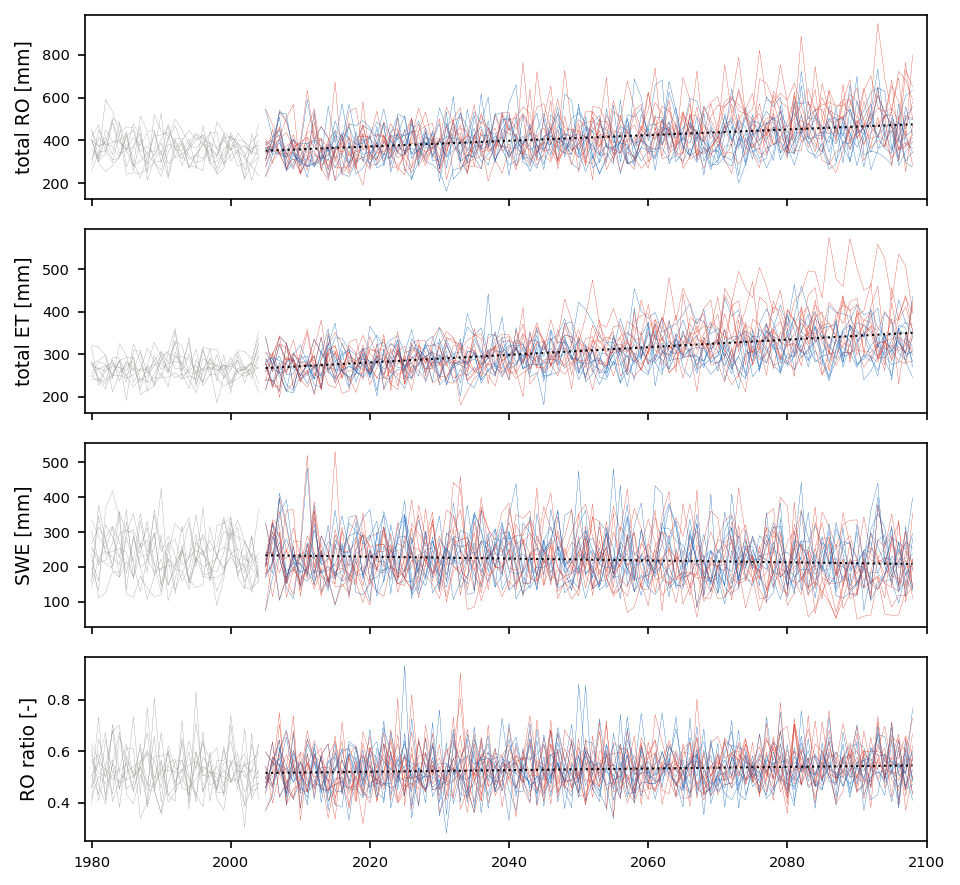

In [20]:
plot_var = ['scalarTotalRunoff_mean','scalarTotalET_mean','scalarSWE', 'runoff_ratio']

mpl.rcParams['axes.labelsize'] = 9 
mpl.rcParams['xtick.labelsize'] = 7 
mpl.rcParams['ytick.labelsize'] = 7 
mpl.rcParams['ytick.labelsize'] = 7 

fig1, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6.5, 6.0), dpi=150)

slope_list = {key: [] for key in plot_var}
intsect_list = {key: [] for key in plot_var}

for case, meta in gcm_runs.items():
    for scen in meta['scen']:
        if scen=='hist':
            c='xkcd:gray'; lw=0.15            
        elif scen=='ssp245' or scen=='rcp45':
            c='#005AB5'; lw=0.15
        elif scen=='ssp370':
            continue
            c='xkcd:green'; lw=0.15
        elif scen=='ssp585' or scen=='rcp85':
            c='#DC3220'; lw=0.15         
            
        if scen == 'hist':
            ds_ann = ds_monthly_region[case][scen].sel(time=slice('1980-01-01','2005-12-31')).resample(time="YS-JAN").mean()
            ds_ann['scalarSWE'] = ds_monthly_region[case][scen]['scalarSWE'].sel(time=slice('1980-01-01','2005-12-31')).resample(time="YS-JAN").max()
        else:
            ds_ann = ds_monthly_region[case][scen].sel(time=slice('2005-01-01','2098-12-31')).resample(time="YS-JAN").mean()
            ds_ann['scalarSWE'] = ds_monthly_region[case][scen]['scalarSWE'].sel(time=slice('2005-01-01','2098-12-31')).resample(time="YS-JAN").max()
        ds_ann['runoff_ratio'] = ds_ann['scalarTotalRunoff_mean']/ds_ann['prec']
        
        for ix, var in enumerate(plot_var):
            if var not in ['scalarSWE', 'runoff_ratio']:
                ds_ann[var] = ds_ann[var]*12
            ds_ann[var].plot(ax=ax[ix], c=c, lw=lw)
            if scen=='hist':
                continue
            years = np.arange(len(ds_ann.time))
            slope, intsect = np.polyfit(years, ds_ann[var].values, 1)
            slope_list[var].append(slope)
            intsect_list[var].append(intsect)
            
        ax[ix].set_xlim(pd.Timestamp('1979-01-01'), pd.Timestamp('2100-01-01'));

for ix, var in enumerate(plot_var):
    slope_ave =  np.sum(slope_list[var])/len(slope_list[var])
    intsect_ave = np.sum(intsect_list[var])/len(intsect_list[var])
    trend = xr.DataArray(
        slope_ave * years + intsect_ave,
        coords={"time": ds_ann.time},
        dims=["time"],
    )
    trend.plot(ax=ax[ix], lw=1, color='k', ls=':')
        
#for ix, var in enumerate(plot_var):
#    df[var].plot(ax=ax[ix], c='xkcd:dark gray', ls='--', lw=1, legend=False, zorder=5)
        
ax[0].set_ylabel('total RO [mm]')
ax[1].set_ylabel('total ET [mm]')
ax[2].set_ylabel('SWE [mm]') #, fontsize='x-small'
ax[3].set_ylabel('RO ratio [-]')

ax[0].set_xlabel('');
ax[1].set_xlabel('');
ax[2].set_xlabel('');
ax[3].set_xlabel('');

plt.tight_layout()
plt.savefig(os.path.join('NB3_figures', f'Fig3_annual_series_{basin}.png'),dpi=300)